<a href="https://colab.research.google.com/github/ovozzx/Machine-Learning/blob/master/%5BDacon%5DTitanic_Survivor_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

💡EDA - 전처리(이상치, 결측치 등) - 표준화 & 정규화 - 모델링(파라미터)

# 0. 라이브러리(필요한 도구) 불러오기

In [107]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping




import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [32]:
!apt-get update
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64

In [33]:
import matplotlib as mpl
import matplotlib.image as img

mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family = 'NanumBarunGothic')



# 1. 데이터 로딩

PassengerID : 탑승객 고유 아이디

Survival : 탑승객 생존 유무 (0: 사망, 1: 생존)

**Pclass** : 등실의 등급

Name : 이름

**Sex** : 성별

**Age** : 나이

**Sibsp** : 함께 탐승한 형제자매, 아내, 남편의 수

**Parch** : 함께 탐승한 부모, 자식의 수

Ticket :티켓 번호

**Fare** : 티켓의 요금

**Cabin** : 객실번호

Embarked : 배에 탑승한 항구 이름 ( C = Cherbourn, Q = Queenstown, S = Southampton)



---




✓ 생존확률(0: 사망, 1: 생존)


In [34]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [35]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [36]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [37]:
train.shape

(891, 12)

# 2. EDA

In [38]:
# feature별 bar 그래프 함수 작성

def bar_chart(feature):
  survived = train[train['Survived']==1][feature].value_counts()
  dead = train[train['Survived']==0][feature].value_counts()
  df = pd.DataFrame([survived, dead])
  df.index = ['Surevived', 'Dead']
  df.plot(kind = 'bar', stacked = True, figsize = (10,5))

In [39]:
train[train['Survived']==1]['Sex']

1      female
2      female
3      female
8      female
9      female
        ...  
875    female
879    female
880    female
887    female
889      male
Name: Sex, Length: 342, dtype: object

In [40]:
train[train['Survived']==1]['Sex'].value_counts()

female    233
male      109
Name: Sex, dtype: int64

(1) Sex(성별) : male(남성)이 많이 죽음

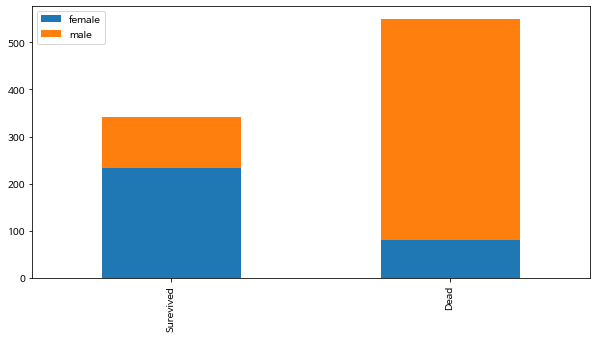

In [41]:
bar_chart('Sex')

(2) Pclass(좌석등급) : 3등급 좌석 사망자 수가 많음

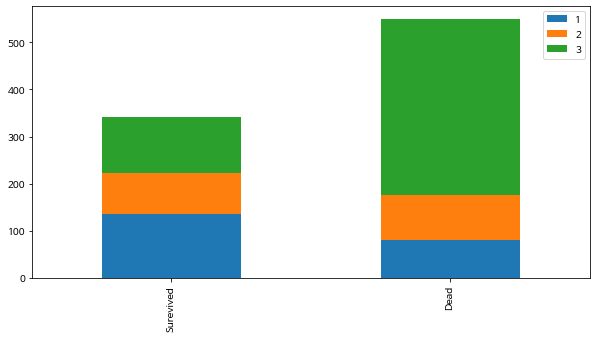

In [42]:
bar_chart('Pclass')

(3) SibSp(함께 탐승한 형제자매, 아내, 남편의 수) : 연관성 애매

0명인 사람이 많이 죽기도 하였지만, 8명인 사람도 죽음

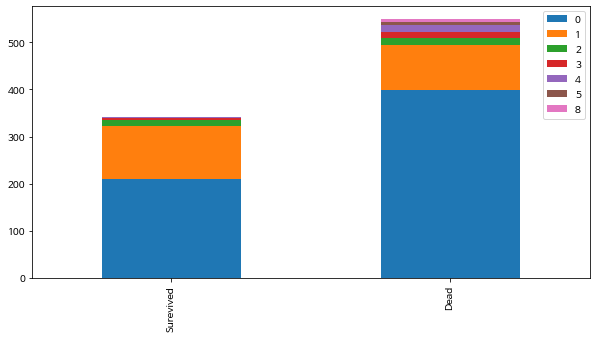

In [43]:
bar_chart('SibSp')

(4) Age(나이) : 

가설 - 어릴수록 생존율이 높을 것이다? ❌

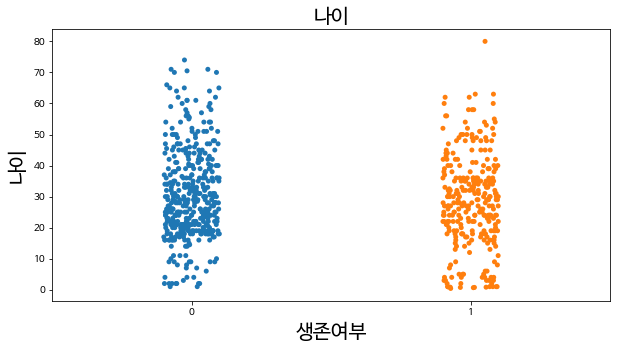

In [44]:
plt.figure(figsize = (10,5))
plt.title('나이',fontsize = 20)
sns.stripplot(x = 'Survived', y = 'Age', data = train, jitter = True)
plt.xlabel('생존여부', fontsize = 20)
plt.ylabel('나이', fontsize = 20)


plt.show()

#0: 사망, 1: 생존

(5) Parch(함께 탐승한 부모, 자식의 수)

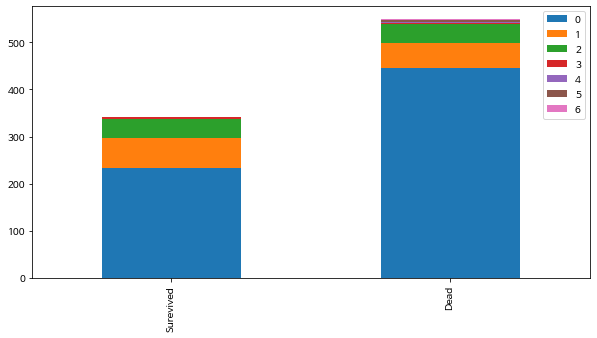

In [45]:
bar_chart('Parch')

(6) Fare(티켓 요금) : 가장 비싼 요금의 티켓 구매자들은 생존

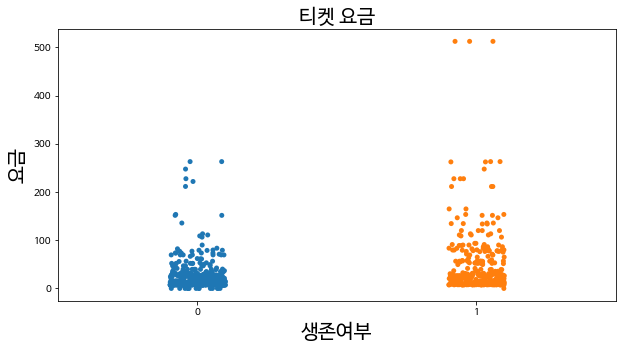

In [46]:
plt.figure(figsize = (10,5))
plt.title('티켓 요금',fontsize = 20)
sns.stripplot(x = 'Survived', y = 'Fare', data = train, jitter = True)
plt.xlabel('생존여부', fontsize = 20)
plt.ylabel('요금', fontsize = 20)


plt.show()

#0: 사망, 1: 생존

(7) Cabin(객실번호) 

In [47]:
train[train['Survived']==1]['Cabin'].value_counts()

B96 B98    4
E101       3
F33        3
B18        2
B20        2
          ..
C32        1
E34        1
C7         1
C54        1
C148       1
Name: Cabin, Length: 101, dtype: int64

# 3. 데이터 확인



In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [49]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [50]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

###✓ describe()

숫자형 (int, float) column들의 기술 통계량을 보여주는 함수

-기술통계량이란?

해당 column을 대표할 수 있는 통계값들을 의미

-기술통계량 종류

count: 해당 column에서 비어 있지 않은 값의 개수

mean: 평균

std: 표준편차

min: 최솟값 (이상치 포함)

25% (Q1): 전체 데이터를 순서대로 정렬했을 때, 아래에서 부터 1/4번째 지점에 있는 값

50% (Q2): 중앙값 (전체 데이터를 순서대로 정렬했을 때, 아래에서 부터 2/4번째 지점에 있는 값)

75% (Q3): 전체 데이터를 순서대로 정렬했을 때, 아래에서 부터 3/4번째 지점에 있는 값

max: 최댓값 (이상치 포함)



-이상치: 울타리 밖에 있는 부분을 이상치라고 정의함

아래쪽 울타리: Q_1Q1​ - 1.5 * IQR1.5∗IQR

위쪽 울타리: Q_3Q3​ + 1.5 * IQR1.5∗IQR

IQRIQR = Q_3 - Q_1Q3​−Q1​


In [51]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 4. 데이터 전처리

1) 이상치 발견 및 제거 (z-score 활용)

2) 표준화 및 정규화  

##⭐️ 정규화

특성 값의 범위를 [0, 1]로 옮김

(X - MIN) / (MAX-MIN) 







## ⭐️ 표준화(Z 점수 정규화)

어떤 특성의 값들이 정규분포, 즉 종모양의 분포를 따른다고 가정하고 값들을 0의 평균, 1의 표준편차를 갖도록 변환, 이상치 잘 처리

(X - 평균) / 표준편차

###✓ pd.DataFrame.fillna()

결측치를 채우고자 하는 column과 결측치를 대신하여 넣고자 하는 (값)을 명시해주어야 합니다.

범주형 변수일 경우, 최빈값으로 대체할 수 있습니다.




### ✓ pd.DataFrame.map({딕셔너리})
딕셔너리에 따라 key값을 value로 바꿈

In [52]:
train['Age'] = train['Age'].fillna(29) #최빈값
train['Sex'] = train['Sex'].map({'male' : 0, 'female' : 1})

test['Age'] = test['Age'].fillna(29)
test['Fare'] = test['Fare'].fillna(32)
test['Sex'] = test['Sex'].map({'male' : 0, 'female' : 1})

In [53]:
#Embarked 데이터를 숫자형으로 변환합니다.
"""
train['Embarked'] = train['Embarked'].fillna(0)
train['Embarked'] = train['Embarked'].map( {'C': 0, 'Q': 1, 'S':2} ).astype(int)
test['Embarked'] = test['Embarked'].map( {'C': 0, 'Q': 1, 'S':2} ).astype(int)
"""

"\ntrain['Embarked'] = train['Embarked'].fillna(0)\ntrain['Embarked'] = train['Embarked'].map( {'C': 0, 'Q': 1, 'S':2} ).astype(int)\ntest['Embarked'] = test['Embarked'].map( {'C': 0, 'Q': 1, 'S':2} ).astype(int)\n"

In [54]:
train = train.drop(['Name', 'Ticket'], axis = 1)
test = test.drop(['Name', 'Ticket'], axis = 1)

In [55]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,0,22.0,1,0,7.2500,NaN,S
1,2,1,1,1,38.0,1,0,71.2833,C85,C
2,3,1,3,1,26.0,0,0,7.9250,NaN,S
3,4,1,1,1,35.0,1,0,53.1000,C123,S
4,5,0,3,0,35.0,0,0,8.0500,NaN,S


In [56]:
train_x = train[['Pclass', 'SibSp','Age', 'Sex', 'Fare']]
train_y = train['Survived']


test_x = test[['Pclass', 'SibSp', 'Age', 'Sex', 'Fare']]

In [57]:
##표준화 : 평균 = 0, 표준편차 = 1
from sklearn.preprocessing import StandardScaler


# StandardScaler객체 생성
scaler = StandardScaler()
# StandardScaler 로 데이터 셋 변환. fit( ) 과 transform( ) 호출.  
scaler.fit(train_x)
train_scaled = scaler.transform(train_x)
train_x = train_scaled

scaler.fit(test_x)
test_scaled = scaler.transform(test_x)
test_x = test_scaled

print(test_x)





[[ 0.87348191 -0.49947002  0.35544516 -0.75592895 -0.49824896]
 [ 0.87348191  0.61699237  1.34516057  1.32287566 -0.51311611]
 [-0.31581919 -0.49947002  2.53281907 -0.75592895 -0.46493053]
 ...
 [ 0.87348191 -0.49947002  0.67215409 -0.75592895 -0.50863373]
 [ 0.87348191 -0.49947002 -0.08002962 -0.75592895 -0.49429012]
 [ 0.87348191  0.61699237 -0.08002962 -0.75592895 -0.23774919]]


In [58]:
##정규화 : [0,1]

from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler객체 생성
scaler = MinMaxScaler()
# MinMaxScaler 로 데이터 셋 변환. fit() 과 transform() 호출.  
scaler.fit(train_x)
train_scaled = scaler.transform(train_x)

train_x = train_scaled 



scaler.fit(test_x)
test_scaled = scaler.transform(test_x)

test_x = test_scaled 


print(test_x)




[[1.         0.         0.4527232  0.         0.01528158]
 [1.         0.125      0.61756561 1.         0.01366309]
 [0.5        0.         0.8153765  0.         0.01890874]
 ...
 [1.         0.         0.50547277 0.         0.01415106]
 [1.         0.         0.38019254 0.         0.01571255]
 [1.         0.125      0.38019254 0.         0.0436405 ]]


In [59]:
train_x.shape

(891, 5)

In [60]:
train_y.shape

(891,)

# 4. 모델 정의 및 학습

- 의사결정나무 : 정확도 0.70435

- ☑️ **로지스틱회귀** : 정확도 0.7527507303

- 랜덤포레스트 : 정화도 0.7024342746

- ☑️ **LightGBM** : 정확도 0.7377312561

- ☑️ **딥러닝** : 정확도 0.756037001

In [61]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [62]:
# kfold 함수

def kfold_func(clf):

  scoring = 'accuracy'
  score = cross_val_score(clf, train_x, train_y, cv=k_fold, n_jobs=1, scoring=scoring)
  print(score)
  print('평균 정확도:', round(np.mean(score)*100,2))

(1) 의사결정나무

In [63]:
#0.70435

# 모델 만들기
DT_model = DecisionTreeClassifier()


In [64]:
kfold_func(DT_model)

[0.77777778 0.75280899 0.82022472 0.75280899 0.82022472 0.79775281
 0.74157303 0.78651685 0.78651685 0.71910112]
평균 정확도: 77.55


In [65]:
# 학습하기
DT_model.fit(train_x, train_y)


DecisionTreeClassifier()

In [66]:
DT_test_y_pred = DT_model.predict(test_x)
DT_test_y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

(2) **로지스틱회귀** : 0.7527507303

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’


In [67]:

#0.73984
    

LR_model = LogisticRegression(random_state = 10, solver='liblinear')



In [68]:
kfold_func(LR_model)


[0.78888889 0.76404494 0.79775281 0.75280899 0.79775281 0.79775281
 0.78651685 0.83146067 0.80898876 0.82022472]
평균 정확도: 79.46


In [69]:

LR_model.fit(train_x, train_y)

LogisticRegression(random_state=10, solver='liblinear')

In [70]:
LR_model.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

- penalty : 정규화의 방법 지정 → l1, l2

- C : 정규화의 강도 지정(작을수록 강도 증가)

In [85]:
%%time


params = { 'penalty' : ['l2', 'l1'],
           'C' : [0.001, 0.01,0.1, 1, 3, 7, 8,10],
           'max_iter' : [3,4,5,10,20,30,50,100,200]
         }


grid_LR = GridSearchCV(LR_model, param_grid = params, scoring = 'accuracy', cv =3 )
grid_LR.fit(train_x, train_y)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_LR.best_params_, grid_LR.best_score_))

최적 하이퍼 파라미터:{'C': 10, 'max_iter': 3, 'penalty': 'l1'}, 최적 평균 정확도:0.796
CPU times: user 1.22 s, sys: 5.08 ms, total: 1.22 s
Wall time: 1.23 s


In [86]:
#0.7527507303
LR_test_y_pred = grid_LR.predict(test_x)
LR_test_y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

(3) 랜덤포레스트

In [73]:
#0.7024342746

# 모델 만들기
RF_model = RandomForestClassifier()


In [74]:
kfold_func(RF_model)


[0.82222222 0.85393258 0.80898876 0.76404494 0.86516854 0.84269663
 0.78651685 0.7752809  0.82022472 0.83146067]
평균 정확도: 81.71


In [75]:
# 학습하기
RF_model.fit(train_x, train_y)

RandomForestClassifier()

In [76]:
RF_test_y_pred = DT_model.predict(test_x)
RF_test_y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

(4) **LightGBM**  : 0.7377312561

In [77]:
#0.7240262902

# 모델 만들기
LG_model = LGBMClassifier()


In [78]:
kfold_func(LG_model)

[0.81111111 0.85393258 0.83146067 0.7752809  0.85393258 0.84269663
 0.79775281 0.80898876 0.82022472 0.79775281]
평균 정확도: 81.93


In [79]:
# 학습하기
LG_model.fit(train_x, train_y)

LGBMClassifier()

In [ ]:
LG_model.get_params().keys()

In [81]:
%%time
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소 → 실제 학습시킬 때 증가시킴
LG_model = LGBMClassifier(random_state = 10)

params = {'max_depth':[64, 128, 160, 200] , 
          'min_child_samples':[20,30, 60,100] ,
          'num_leaves':[8,16, 32, 64], 
          'subsample':[0,5, 0.8, 1],
          'n_estimators' : [60,100,200,300]
          }

# cv는 3으로 지정 
grid_LG = GridSearchCV(LG_model, param_grid=params, cv=3)
grid_LG.fit(train_x, train_y)


print('최적 하이퍼 파라미터:{0}, \n 최적 평균 정확도:{1:.3f}'.format(grid_LG.best_params_, grid_LG.best_score_))

최적 하이퍼 파라미터:{'max_depth': 64, 'min_child_samples': 60, 'n_estimators': 300, 'num_leaves': 16, 'subsample': 0.8}, 
 최적 평균 정확도:0.826
CPU times: user 2min 5s, sys: 8.02 s, total: 2min 13s
Wall time: 1min 20s


In [83]:
LG_test_y_pred = grid_LG.predict(test_x)
LG_test_y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

(5) **딥러닝** : 

- 캐글 Score: 0.77511

- 데이콘 Score: 0.7534323272


GridSeach?

In [88]:
#target, label, 
train_y.index

RangeIndex(start=0, stop=891, step=1)

In [89]:
type(train_y)

pandas.core.series.Series

In [90]:
train_y.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [91]:
# 데이터셋에 존재하는 컬럼별 레이블의 개수를 확인하기 위해 사용
train_y.nunique()


2

In [92]:

from tensorflow.keras.utils import to_categorical

train_y = to_categorical(train_y)
train_y 


#원핫인코딩 0 1 1...

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [104]:
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf

DL = models.Sequential(name = 'Classification')
DL.add(layers.Dense(64, activation = 'relu', input_shape = (5,))) #특성 13개 input
DL.add(layers.Dense(32, activation = 'relu'))
DL.add(layers.Dense(2, activation = 'sigmoid')) #0~1 사이의 값 확률?

In [117]:
DL.compile(loss = 'binary_crossentropy',
               optimizer = tf.keras.optimizers.Adam(lr=0.0005),
               metrics = ['accuracy'])

In [118]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50)


In [119]:
%%time

Hist_DL = DL.fit(train_x, train_y, epochs = 300, batch_size = 2, callbacks = [es])
                         

Epoch 1/300
446/446 [==============================] - 3s 3ms/step - loss: 0.3496 - accuracy: 0.8406
Epoch 2/300
446/446 [==============================] - 2s 5ms/step - loss: 0.3485 - accuracy: 0.8406
Epoch 3/300
446/446 [==============================] - 1s 3ms/step - loss: 0.3485 - accuracy: 0.8395
Epoch 4/300
446/446 [==============================] - 1s 3ms/step - loss: 0.3484 - accuracy: 0.8406
Epoch 5/300
446/446 [==============================] - 1s 3ms/step - loss: 0.3486 - accuracy: 0.8406
Epoch 6/300
446/446 [==============================] - 1s 3ms/step - loss: 0.3488 - accuracy: 0.8395
Epoch 7/300
446/446 [==============================] - 1s 2ms/step - loss: 0.3482 - accuracy: 0.8395
Epoch 8/300
446/446 [==============================] - 1s 2ms/step - loss: 0.3483 - accuracy: 0.8406
Epoch 9/300
446/446 [==============================] - 1s 2ms/step - loss: 0.3485 - accuracy: 0.8395
Epoch 10/300
446/446 [==============================] - 1s 2ms/step - loss: 0.3481 - accura

In [120]:
DL_test_y_pred = DL.predict(test_x)
print(DL_test_y_pred.shape)
DL_test_y_pred

# 0,1 각각의 확률

(418, 2)


array([[8.75257254e-01, 1.24742687e-01],
       [5.86396337e-01, 4.13603604e-01],
       [9.51453507e-01, 4.85464931e-02],
       [8.87446761e-01, 1.12553209e-01],
       [5.25024414e-01, 4.74975556e-01],
       [9.09722865e-01, 9.02771652e-02],
       [4.18350488e-01, 5.81649542e-01],
       [9.29058552e-01, 7.09414184e-02],
       [3.99024665e-01, 6.00975335e-01],
       [9.21503186e-01, 7.84968734e-02],
       [8.86998296e-01, 1.13001674e-01],
       [6.14479721e-01, 3.85520250e-01],
       [2.01561978e-17, 1.00000000e+00],
       [9.84268010e-01, 1.57319903e-02],
       [2.41075444e-08, 1.00000000e+00],
       [6.34647608e-02, 9.36535239e-01],
       [9.18329954e-01, 8.16700161e-02],
       [9.05607581e-01, 9.43923295e-02],
       [5.10024250e-01, 4.89975691e-01],
       [5.84968686e-01, 4.15031254e-01],
       [4.62709218e-01, 5.37290752e-01],
       [7.80282699e-06, 9.99992251e-01],
       [1.21064535e-13, 1.00000000e+00],
       [4.62709218e-01, 5.37290752e-01],
       [1.169917

In [121]:
arr = []

for i in DL_test_y_pred :
  if i[0] > i[1] :
    arr.append(0)
  else :
    arr.append(1)    

DL_test_y_pred = arr

In [122]:
DL_test_y_pred[:10]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0]

### GridSearchCV

In [ ]:
!pip install -U keras-tuner
import kerastuner as kt

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
import keras
import tensorflow as tf
import IPython
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# 모델 만들기
tf.random.set_seed(7)

def model_builder(nodes=16, activation='relu'):

  model = Sequential()
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(2, activation='sigmoid')) # 이진분류니까 노드수 1, 활성함수로는 시그모이드

  model.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=['accuracy'])

  return model
  
  
#keras.wrapper 분류기
model = KerasClassifier(build_fn=model_builder, verbose=0)

# GridSearch 파라미터 설정
batch_size = [50, 100, 300]
epochs = [10, 20, 30]
nodes = [64, 128, 256]
activation = ['relu', 'sigmoid']
param_grid = dict(batch_size=batch_size, epochs=epochs, nodes=nodes, activation=activation)


# GridSearch CV를 만들기
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)
grid_result = grid.fit(train_x, train_y)

# 최적의 결과값을 낸 파라미터를 출력합니다
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

In [ ]:
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 6, activation = 'relu', input_dim = 4))
    classifier.add(Dense(units = 6, activation = 'relu'))
    classifier.add(Dense(units = 2, activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [ ]:
classifier = KerasClassifier(build_fn = build_classifier)

In [ ]:
parameters = {'batch_size': [25, 32],
              'epochs': [80, 100],
              'optimizer': ['adam', 'rmsprop']}

In [ ]:
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)

In [ ]:
grid_search = grid_search.fit(train_x, train_y)

In [ ]:
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

print('best_parameters : {0},  best_accuracy {1}' .format(best_parameters,best_accuracy))

# 4. 제출 파일 생성

In [123]:
submission = pd.read_csv("submission.csv")
submission['Survived'] = DL_test_y_pred
submission.to_csv('DL_submission.csv', index = False)

# 5. 성능 평가